## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
%%writefile qlearning.py
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #<YOUR CODE HERE>
        value = self.get_qvalue(state, possible_actions[0])
        for action in possible_actions:
            value_a = self.get_qvalue(state, action)
            if (value_a > value):
                value = value_a
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #<YOUR CODE HERE>
        qvalue = (1-learning_rate)*self.get_qvalue(state, action) + learning_rate*(reward + gamma*self.get_value(next_state))
        
        self.set_qvalue(state, action, qvalue)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE>
        value = self.get_qvalue(state, possible_actions[0])
        best_action = possible_actions[0]
        for action in possible_actions:
            value_a = self.get_qvalue(state, action)
            if (value_a > value):
                value = value_a
                best_action = action
        return best_action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE>
        if (random.random()<epsilon):
            chosen_action=random.choice(possible_actions)
        else:
            chosen_action=self.get_best_action(state)
        
        return chosen_action

Overwriting qlearning.py


### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [3]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [4]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

In [5]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s) #<YOUR CODE>
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        agent.update(s, a, r, next_s) #<YOUR CODE HERE>
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward
    
        
    

eps = 2.9191091959171894e-05 mean reward = 6.9


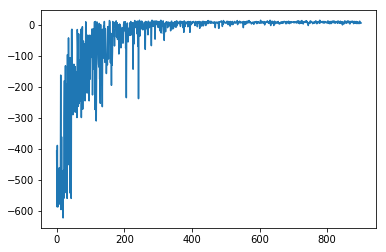

In [6]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
        

### Submit to Coursera I

In [7]:
submit_rewards1 = rewards.copy()
#from submit import submit_qlearning1
#submit_qlearning1(rewards, "gope@wisc.edu", "9B2Jk2M5g5RaK2zO")

# Binarized state spaces

Use agent to train efficiently on CartPole-v0.
This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state:[ 0.00064057 -0.01041272 -0.01412923  0.0186725 ]


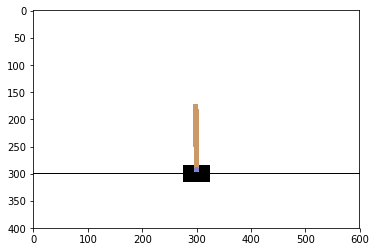

In [8]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

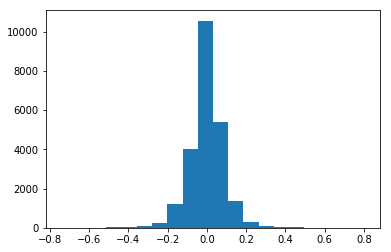

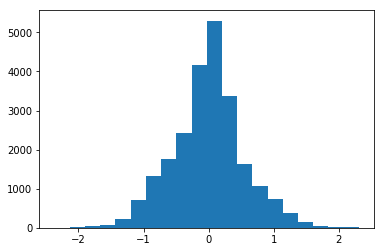

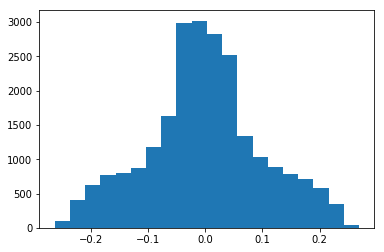

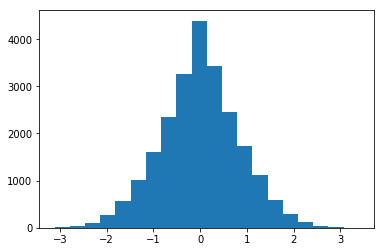

In [9]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

In [10]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self, state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        state_rounded = []
        for obs_i in range(env.observation_space.shape[0]):
            state_rounded.append(round(state[obs_i], 1))
        
        return tuple(state_rounded) #tuple(state)

In [11]:
env = Binarizer(gym.make("CartPole-v0"))

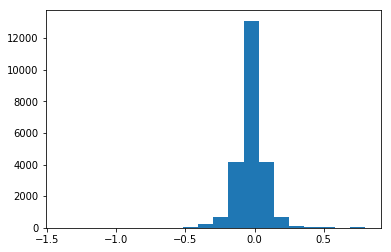

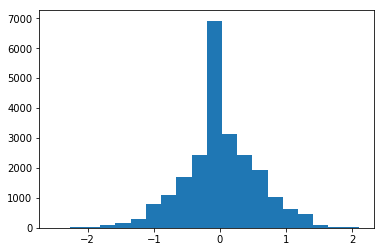

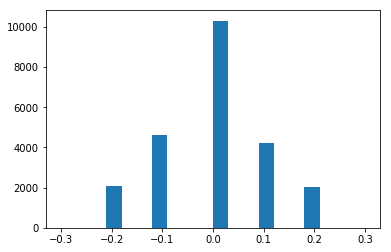

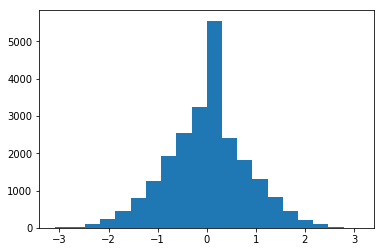

In [12]:
all_states = []
for _ in range(1000):
#for _ in range(1):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.


In [29]:
#agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
#                       getLegalActions = lambda s: range(n_actions))
agent = QLearningAgent(alpha=0.5, epsilon=0.12, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))


eps = 0.03650072903004521 mean reward = 106.1


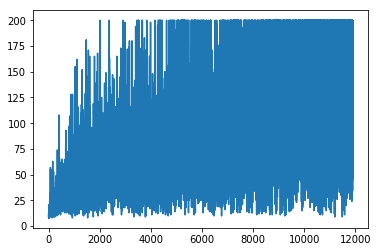

In [30]:
rewards = []
for i in range(12000):
    #print (i, ": ", agent.epsilon)
    rewards.append(play_and_train(env,agent))   
    
    #OPTIONAL YOUR CODE: adjust epsilon
    agent.epsilon = agent.epsilon*0.9999
    if i %100 ==0:
        clear_output(True)
        #print (len(agent._qvalues))
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
        

### Submit to Coursera II

In [98]:
#from submit import submit_qlearning2
#submit_qlearning2(rewards, "gope@wisc.edu", "9B2Jk2M5g5RaK2zO")

submit_rewards2 = rewards.copy()
from submit import submit_qlearning
submit_qlearning(submit_rewards1, submit_rewards2, "gope@wisc.edu", "qzUEZcKcLNLLRUPt")

Submitted to Coursera platform. See results on assignment page!
